This notebook shows how to use the SWOT PIXC processing tools. WORK IN PROGRESS.

NOTE to self: Use HyroEO environment for downloading SWOT PIXC data (uv env with proper netcdf with hdf5 installed), but use hydroeo (mamba env) for processing (no package errors with scipy and other geospatial packages)

In [1]:
# First lets load the needed packages
import sys
import geopandas as gpd
import shapely.geometry as geometry
import shapely
import datetime
import numpy as np
import pandas as pd
import os
import glob
import rioxarray
import matplotlib.pyplot as plt 
from scipy.stats import binned_statistic_2d
from rasterio.transform import from_origin
import rasterio





outdir = "C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\"
if not os.path.exists(outdir):
    os.makedirs(outdir)

swot_raster_dir = "C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\"
if not os.path.exists(swot_raster_dir):
    os.makedirs(swot_raster_dir)

hist_dir = "C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\histograms\\"
if not os.path.exists(hist_dir):
    os.makedirs(hist_dir)

### Function list

In [9]:

def load_trimmed_pixc_data(trimmed_filelist):
    gdf_pixc_all = gpd.GeoDataFrame()
    for trimmed_file in trimmed_filelist:
        # check file size - skip if 0 bytes
        if os.path.getsize(trimmed_file) < 10000:  # less than 10 KB
            print(f"Skipping empty file: {trimmed_file}")
            continue

        str_date = os.path.basename(trimmed_file).split("_")[-4]
        # parse yyyymmddThhmmss to datetime
        t = datetime.datetime.strptime(str_date, "%Y%m%dT%H%M%S")
        gdf_temp = gpd.read_file(trimmed_file)
        gdf_temp['date'] = t
        # set index to date
        gdf_temp = gdf_temp.set_index('date')
        gdf_pixc_all = pd.concat([gdf_pixc_all, gdf_temp])
    
    return gdf_pixc_all

def grid_from_shp(shapefile_utm: gpd.GeoDataFrame, grid_size: float, buffer: float = 0.0, plotFlag=False) -> gpd.GeoDataFrame:

    # shapefile: input shapefile to cover with grid in UTM coordinates
    # grid_size: size of grid cells in meters
    # buffer: buffer around shapefile extent in meters


    # Create a grid covering the shapefile extent
    bounds = shapefile_utm.total_bounds  # (minx, miny, maxx, maxy)
    grid_box = shapely.geometry.box(shapefile_utm.total_bounds[0], shapefile_utm.total_bounds[1], shapefile_utm.total_bounds[2], shapefile_utm.total_bounds[3]).buffer(buffer)  # small buffer to ensure coverage

    pixel_half_size = grid_size / 2
    x_coords = np.arange(grid_box.bounds[0] + pixel_half_size, grid_box.bounds[2]-pixel_half_size, grid_size)
    y_coords = np.arange(grid_box.bounds[1] + pixel_half_size, grid_box.bounds[3]-pixel_half_size, grid_size)
    X, Y = np.meshgrid(x_coords, y_coords)
    x_coords_flat = X.flatten()
    y_coords_flat = Y.flatten()

    if plotFlag:
        fig, ax = plt.subplots(figsize=(10, 10))
        shapefile_utm.plot(ax=ax)
        grid_box_gdf = gpd.GeoDataFrame(geometry=[grid_box], crs=shapefile_utm.crs)
        grid_box_gdf.plot(ax=ax, facecolor="none", edgecolor="red")
        plt.scatter(X, Y, color='blue', s=0.1)
        plt.show()

    return x_coords_flat, y_coords_flat


def plot_hist_map(gdf_date, field, shapefile_ll, date, outdir):

    fig, (ax_hist, ax_map) = plt.subplots(
        ncols=2,
        figsize=(16, 8),
        gridspec_kw={"width_ratios": [1, 1]}
    )

    ax_hist.hist(
                gdf_date[field],
                bins=100,
                alpha=0.4,
                density=True,
                label=str(date)
            )

    ax_hist.set_xlabel(f"{field}")
    ax_hist.set_ylabel("Probability density")

    # Background
    shapefile_ll.plot(ax=ax_map, color="lightgrey", edgecolor="none")

    # min and max set as 3 std away from mean
    vmin = gdf_date[field].mean() - 3 * gdf_date[field].std()
    vmax = gdf_date[field].mean() + 2 * gdf_date[field].std()

    # Points colored by height
    gdf_date.plot(
        ax=ax_map,
        column=field,
        legend=True,
        markersize=0.5,
        vmin=vmin,
        vmax=vmax
    )

    ax_map.set_title(str(date))
    ax_map.set_axis_off()

    # save figure
    fig.savefig(outdir + f"{date}.png", dpi=300)

    # close figure
    plt.close(fig)


def grid_sampling(shapefile_utm: gpd.GeoDataFrame, 
                  gdf_points: gpd.GeoDataFrame, 
                  buffer: float = 0.0, 
                  field: str = 'heightEGM', 
                  stat_method: str = 'median', 
                  grid_resolution: float = 100, 
                  filedate: str = ' ', 
                  plotFlag=False, 
                  countFlag=False,
                  writeGeoTIFF=False) -> np.ndarray:
    
    # Function that grids point data to specified resolution over shapefile extent
    # shapefile_utm: input shapefile to cover with grid in UTM coordinates
    # gdf_points: input geopandas dataframe with point data to grid
    # buffer: buffer around shapefile extent in meters
    # field: field in gdf_points to grid
    # stat_method: statistic to compute in each grid cell ('median', 'mean', etc.)
    # grid_resolution: size of grid cells in meters
    # filedate: string to append to output filename - e.g., date or 'all_dates'
    # plotFlag: whether to plot the gridded result
    # writeGeoTIFF: whether to write the gridded result to GeoTIFF


    x_grid, y_grid = grid_from_shp(shapefile_utm, grid_size=grid_resolution, buffer=buffer, plotFlag=plotFlag)

    # convert gdf_pixc_all to UTM
    gdf_points = gdf_points.to_crs(shapefile_utm.crs)

    # Extract swot pixc arrays
    x = gdf_points.geometry.x.to_numpy()
    y = gdf_points.geometry.y.to_numpy()
    z = gdf_points[field].to_numpy()

    # Grid resolution
    dx = dy = grid_resolution

    # Grid extent (match your defined grid)
    xmin = x_grid.min()
    xmax = x_grid.max()
    ymin = y_grid.min()
    ymax = y_grid.max()

    # Number of cells
    nx = int(np.ceil((xmax - xmin) / dx))
    ny = int(np.ceil((ymax - ymin) / dy))

    # Pure scipy method (fast)
    x_edges = xmin + dx * np.arange(nx + 1)
    y_edges = ymin + dy * np.arange(ny + 1)

    # create 2D binned statistic for median
    stat_raster, _, _, _ = binned_statistic_2d(
        y, x, z,
        statistic=stat_method,
        bins=[y_edges, x_edges]
    )

    count_raster, _, _, _ = binned_statistic_2d(
        y, x, None,
        statistic="count",
        bins=[y_edges, x_edges]
    )

    stat_raster = np.flipud(stat_raster)
    count_raster = np.flipud(count_raster)

    transform = from_origin(
        xmin,
        ymax,
        dx,
        dy
    )

    if plotFlag:
        # Plot results
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
        c1 = ax1.imshow(stat_raster, cmap="viridis", extent=(xmin, xmax, ymin, ymax))
        ax1.set_title(f"{stat_method.capitalize()} {field}")
        c2 = ax2.imshow(count_raster, cmap="viridis", extent=(xmin, xmax, ymin, ymax))
        ax2.set_title("Count of Points")

    # Write to geotiff
    if writeGeoTIFF:
        with rasterio.open(
            swot_raster_dir+f"{filedate}_{field}.tif",
            "w",
            driver="GTiff",
            height=stat_raster.shape[0],
            width=stat_raster.shape[1],
            count=1,
            dtype=stat_raster.dtype,
            crs=shapefile_utm.crs,
            transform=transform,
            nodata=np.nan
        ) as dst:
            dst.write(stat_raster, 1)

        if countFlag:
            with rasterio.open(
                swot_raster_dir+f"{filedate}_count.tif",
                "w",
                driver="GTiff",
                height=count_raster.shape[0],
                width=count_raster.shape[1],
                count=1,
                dtype=count_raster.dtype,
                crs=shapefile_utm.crs,
                transform=transform,
                nodata=np.nan
            ) as dst:
                dst.write(count_raster, 1)

    return stat_raster

### View area of interest

<Axes: >

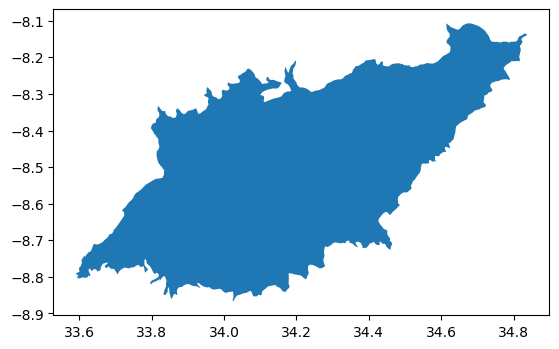

In [3]:
wetland_utm = gpd.read_file("C:\\Users\\safr\\Documents\\test_altimetry_project\\shapefiles\\wetland_fans_domain_37S.shp")
wetland_ll = wetland_utm.to_crs("EPSG:4326")
wetland_ll.plot()

### Search for and download granules filtered by bbox and time

KeyboardInterrupt: 

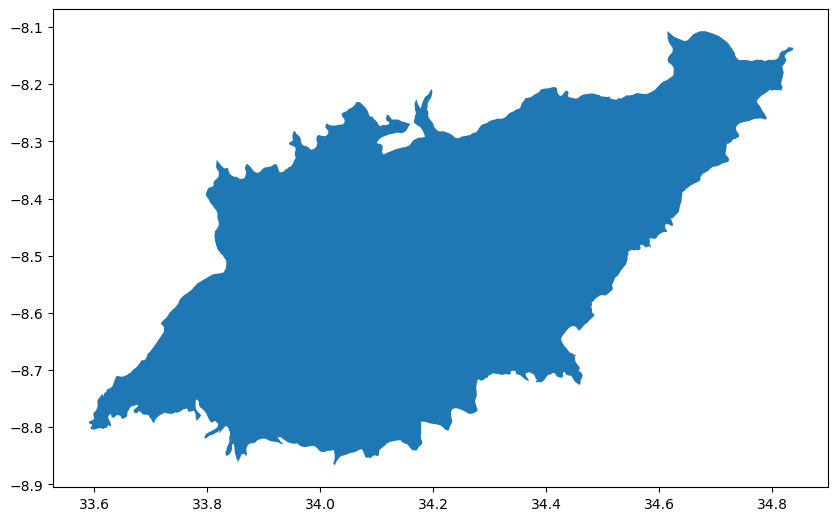

In [4]:
# Read in trimmed data, save to gdf_pixc_all
gdf_pixc_all = load_trimmed_pixc_data(glob.glob("C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\*_trimmed.geojson")[0:15])

# plot
fig, ax = plt.subplots(figsize=(10,10))
wetland_ll.plot(ax=ax)
gdf_pixc_all.plot(ax=ax,column='heightEGM',s=0.5)

C:\Users\safr\AppData\Local\Temp\ipykernel_19768\2058788319.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(dates))  # or tab20 if many dates


,height,heightEGM,lat,lon,geoid,solid_earth_tide,load_tide,pole_tide,class,water_frac,phase_noise_std,dheight_dphase,sig0,geometry,timestamp
date,,,,,,,,,,,,,,,
2023-07-28 02:34:53,1262.3553,1275.9749,-8.857156,33.855016,-13.568743,-0.061513,0.010042,0.000780,3.0,0.246260,0.143576,-7.627758,3.468229,POINT (33.85502 -8.85716),2023-07-28
2023-07-28 02:34:53,1235.5933,1249.2991,-8.848952,33.851782,-13.655022,-0.061504,0.010039,0.000779,3.0,0.282769,0.140401,-7.554225,3.895596,POINT (33.85178 -8.84895),2023-07-28
2023-07-28 02:34:53,1253.4138,1267.0839,-8.849335,33.834252,-13.619216,-0.061557,0.010032,0.000780,3.0,0.171959,0.193401,-7.266195,2.261579,POINT (33.83425 -8.84933),2023-07-28
2023-07-28 02:34:53,1249.6873,1263.3636,-8.848741,33.834252,-13.625625,-0.061555,0.010032,0.000780,3.0,0.137404,0.162680,-7.264735,1.890522,POINT (33.83425 -8.84874),2023-07-28
2023-07-28 02:34:53,1249.5082,1263.1846,-8.848720,33.834115,-13.625597,-0.061556,0.010032,0.000780,3.0,0.127135,0.162680,-7.262435,1.911662,POINT (33.83412 -8.84872),2023-07-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07 00:57:21,1021.8242,1037.4059,-8.140015,34.729106,-15.715380,0.122525,0.010225,0.000900,3.0,1.164030,0.104948,-0.051051,12.090449,POINT (34.72911 -8.14001),2023-08-07
2023-08-07 00:57:21,1023.3185,1038.9005,-8.139979,34.728866,-15.715640,0.122525,0.010225,0.000900,4.0,5.799796,0.058542,-0.047009,435.574860,POINT (34.72887 -8.13998),2023-08-07
2023-08-07 00:57:21,1021.7726,1037.3544,-8.139794,34.728958,-15.715416,0.122525,0.010225,0.000900,3.0,0.745790,0.110018,-0.048069,9.869122,POINT (34.72896 -8.13979),2023-08-07


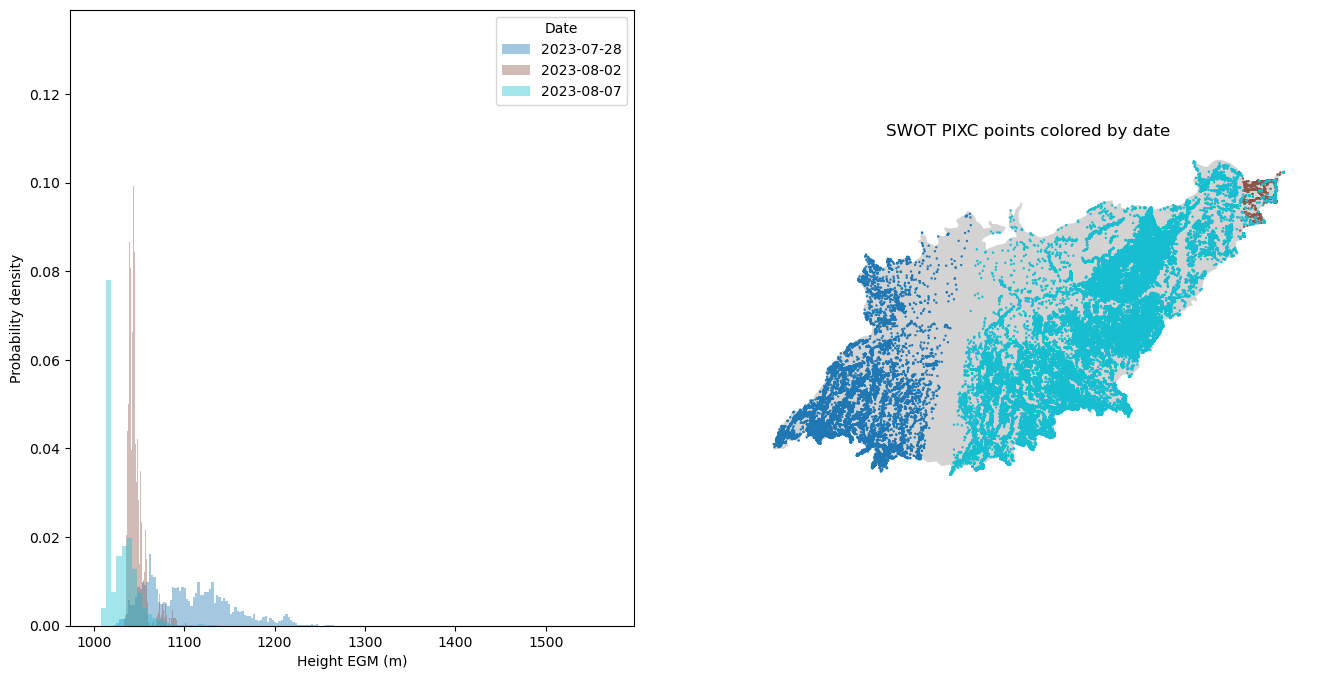

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

gdf_pixc_all['timestamp'] = gdf_pixc_all.index.date


dates = sorted(gdf_pixc_all['timestamp'].unique())
cmap = cm.get_cmap("tab10", len(dates))  # or tab20 if many dates

date_to_color = {
    date: cmap(i) for i, date in enumerate(dates)
}

fig, (ax_hist, ax_map) = plt.subplots(
    ncols=2,
    figsize=(16, 8),
    gridspec_kw={"width_ratios": [1, 1]}
)

for date, grp in gdf_pixc_all.groupby('timestamp'):
    ax_hist.hist(
        grp['heightEGM'],
        bins=100,
        alpha=0.4,
        color=date_to_color[date],
        density=True,
        label=str(date)
    )

ax_hist.set_xlabel("Height EGM (m)")
ax_hist.set_ylabel("Probability density")
ax_hist.legend(title="Date")

# Background
wetland_ll.plot(ax=ax_map, color="lightgrey", edgecolor="none")

# Points colored by date
gdf_pixc_all.plot(
    ax=ax_map,
    color=[date_to_color[date] for date in gdf_pixc_all['timestamp']],
    categorical=True,
    legend=True,
    markersize=0.5
)

ax_map.set_title("SWOT PIXC points colored by date")
ax_map.set_axis_off()

gdf_pixc_all

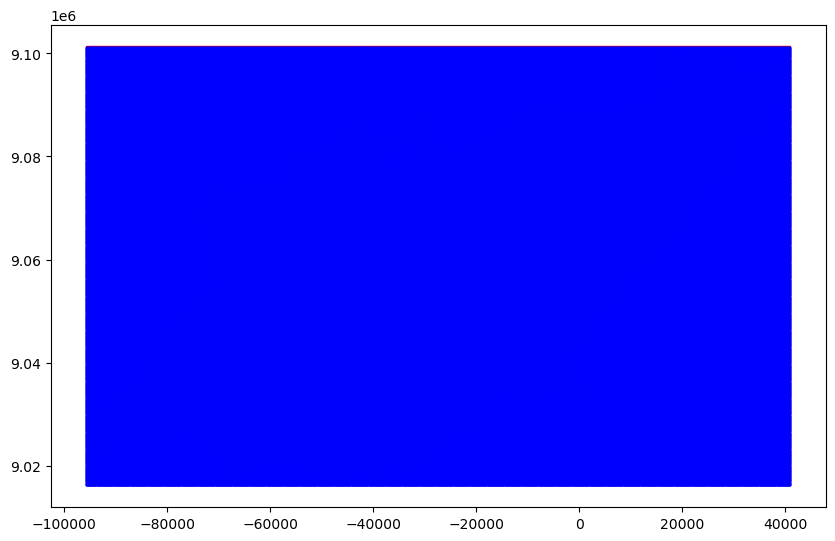

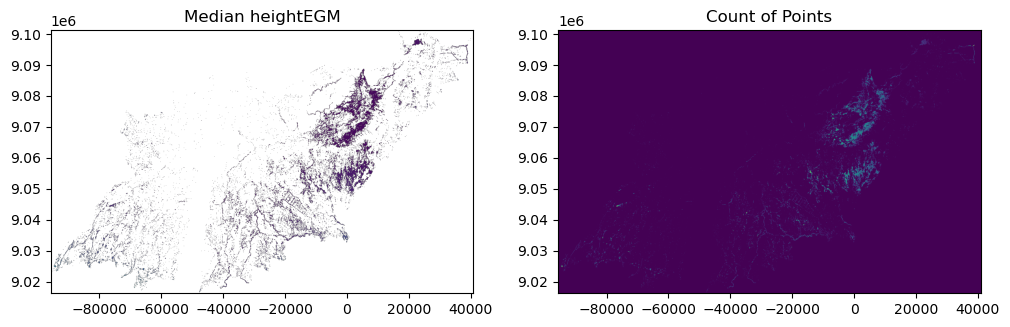

In [ ]:
# First, try simple binning to 100m grid cells, taking median of points in each cell
grid_size = 500  # in meters
wetland_utm = wetland_ll.to_crs(epsg=32737)  # UTM zone 37S
gdf_pixc_all_utm = gdf_pixc_all.to_crs(epsg=32737)

# Test for all dates
stat_raster = grid_sampling(
    shapefile_utm=wetland_utm,
    gdf_points=gdf_pixc_all_utm,
    buffer=0.01,
    field='heightEGM',
    stat_method='median',
    grid_resolution=100,
    filedate='all_dates_sub',
    plotFlag=True,
    writeGeoTIFF=True
)

In [4]:
trimmed_filelist = glob.glob("C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\*_trimmed.geojson")
trimmed_filelist
print(len(trimmed_filelist))


332


In [5]:
# delete files from os that are less than 10 KB
for file in trimmed_filelist:
    if os.path.getsize(file) < 10000:
        print(f"file size: {os.path.getsize(file)} bytes")
        os.remove(file)
        print(f"Deleted empty file: {file}")

In [6]:
trimmed_filelist = glob.glob("C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\*_trimmed.geojson")
trimmed_filelist
print(len(trimmed_filelist))

332


In [ ]:

# take subset of files for testing, with dates between 2024-01-01 and 2024-03-01
trimmed_filelist_sub = []
for f in trimmed_filelist:
    str_date = os.path.basename(f).split("_")[-4]
    t = datetime.datetime.strptime(str_date, "%Y%m%dT%H%M%S")
    if t >= datetime.datetime(2024, 1, 1) and t < datetime.datetime(2024, 3, 1):
        trimmed_filelist_sub.append(f)

trimmed_filelist_sub
# now take a random sample of 5 files from this subset for testing
import random
trimmed_filelist_sample = random.sample(trimmed_filelist_sub, 5)
trimmed_filelist_sample

['C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\SWOT_L2_HR_PIXC_011_068_169L_20240217T065935_20240217T065946_PGD0_01_trimmed.geojson',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\SWOT_L2_HR_PIXC_011_346_169R_20240227T052152_20240227T052203_PGD0_01_trimmed.geojson',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\SWOT_L2_HR_PIXC_010_471_140R_20240210T194253_20240210T194304_PGD0_01_trimmed.geojson',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\SWOT_L2_HR_PIXC_009_346_170R_20240116T115151_20240116T115202_PGD0_01_trimmed.geojson',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\SWOT_L2_HR_PIXC_010_471_141R_20240210T194303_20240210T194314_PGD0_01_trimmed.geojson']

In [8]:
trimmed_file = list(trimmed_filelist)

gdf_sub = gpd.read_file(trimmed_file[0])
gdf_sub

,height,heightEGM,lat,lon,geoid,solid_earth_tide,load_tide,pole_tide,class,water_frac,phase_noise_std,dheight_dphase,sig0,geometry
0,1262.3553,1275.9749,-8.857156,33.855016,-13.568743,-0.061513,0.010042,0.000780,3.0,0.246260,0.143576,-7.627758,3.468229,POINT (33.85502 -8.85716)
1,1235.5933,1249.2991,-8.848952,33.851782,-13.655022,-0.061504,0.010039,0.000779,3.0,0.282769,0.140401,-7.554225,3.895596,POINT (33.85178 -8.84895)
2,1253.4138,1267.0839,-8.849335,33.834252,-13.619216,-0.061557,0.010032,0.000780,3.0,0.171959,0.193401,-7.266195,2.261579,POINT (33.83425 -8.84933)
3,1249.6873,1263.3636,-8.848741,33.834252,-13.625625,-0.061555,0.010032,0.000780,3.0,0.137404,0.162680,-7.264735,1.890522,POINT (33.83425 -8.84874)
4,1249.5082,1263.1846,-8.848720,33.834115,-13.625597,-0.061556,0.010032,0.000780,3.0,0.127135,0.162680,-7.262435,1.911662,POINT (33.83412 -8.84872)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,1073.6777,1088.3397,-8.681461,33.731986,-14.611090,-0.061466,0.009948,0.000767,3.0,0.073571,0.082874,-5.168933,1.271885,POINT (33.73199 -8.68146)
16308,1075.2905,1089.9604,-8.681376,33.734089,-14.619178,-0.061459,0.009948,0.000767,3.0,0.193613,0.063642,-5.203329,3.015421,POINT (33.73409 -8.68138)
16309,1074.1361,1088.8013,-8.681374,33.732736,-14.614261,-0.061463,0.009948,0.000767,3.0,0.259320,0.077055,-5.181063,3.892400,POINT (33.73274 -8.68137)
16310,1073.9117,1088.5763,-8.681344,33.732536,-14.613662,-0.061464,0.009948,0.000767,3.0,0.052165,0.063054,-5.177691,1.020473,POINT (33.73254 -8.68134)


In [11]:
# Now, loop though daily trimmed files, plot histograms for each, create rasters for each at specified resolution
from tqdm import tqdm

# ########### USER INPUT
selField = 'water_frac'  # or 'heightEGM', 'phase_noise_std', 'dheight_dphase'
selMetric = 'median'  # or 'mean', 'max', etc.
trimmed_filelist = glob.glob("C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\*_trimmed.geojson")

# for raster
grid_size = 100  # in meters
wetland_utm = wetland_ll.to_crs(epsg=32737)  # UTM zone 37S


unique_dates = set()
for trimmed_file in trimmed_filelist:
    # check file size - skip if 0 bytes
    if os.path.getsize(trimmed_file) < 10000:  # less than 10 KB
        print(f"Skipping empty file: {trimmed_file}")
        continue

    str_date = os.path.basename(trimmed_file).split("_")[-4]

    # check if raster has already been processed for this date
    raster_date = str_date[0:4] + "-" + str_date[4:6] + "-" + str_date[6:8]
    raster_filename = swot_raster_dir+f"{raster_date}_res100_{selField}.tif"
    if os.path.exists(raster_filename):
        print(f"Raster already exists for date {raster_date}, skipping processing.")
        continue

    # parse yyyymmddThhmmss to datetime
    t = datetime.datetime.strptime(str_date, "%Y%m%dT%H%M%S")
    unique_dates.add(t.date())

for date in tqdm(sorted(unique_dates), desc="Processing dates"):
    # Print current date being processed, with tqdm progress bar
    
    tqdm.write(f"Processing date: {date.strftime('%Y-%m-%d')}")

    ########### Load data for this date
    filenames_for_date = [f for f in trimmed_filelist if date.strftime("%Y%m%d") in f]
    gdf_date = load_trimmed_pixc_data(filenames_for_date)
    # for raster creation
    gdf_date_utm = gdf_date.to_crs(wetland_utm.crs)

    ########## Plot histogram of heights for this date and plot location map, save to file

    plot_hist_map(gdf_date, field=selField, shapefile_ll=wetland_ll, date=date, outdir=hist_dir)

    ########### Create raster for this date at specified resolution

    stat_raster = grid_sampling(
        shapefile_utm=wetland_utm,
        gdf_points=gdf_date_utm,
        buffer=0.01,
        field=selField,
        stat_method=selMetric,
        grid_resolution=grid_size,
        filedate=str(date)+'_res'+str(grid_size),
        plotFlag=False,
        countFlag=False,
        writeGeoTIFF=True
    )
        

Processing dates:   0%|          | 0/135 [00:00<?, ?it/s]

Processing date: 2023-07-28


Processing dates:   1%|          | 1/135 [00:02<06:23,  2.86s/it]

Processing date: 2023-08-02


Processing dates:   1%|▏         | 2/135 [00:03<03:51,  1.74s/it]

Processing date: 2023-08-07


Processing dates:   2%|▏         | 3/135 [00:23<22:02, 10.02s/it]

Processing date: 2023-09-17


Processing dates:   3%|▎         | 4/135 [00:46<33:10, 15.20s/it]

Processing date: 2023-09-28


Processing dates:   4%|▎         | 5/135 [00:49<22:46, 10.51s/it]

Processing date: 2023-10-04


Processing dates:   4%|▍         | 6/135 [00:49<15:30,  7.22s/it]

Processing date: 2023-10-08


Processing dates:   5%|▌         | 7/135 [01:05<21:14,  9.96s/it]

Processing date: 2023-10-15


Processing dates:   6%|▌         | 8/135 [01:28<29:59, 14.17s/it]

Processing date: 2023-10-19


Processing dates:   7%|▋         | 9/135 [01:30<21:58, 10.46s/it]

Processing date: 2023-10-25


Processing dates:   7%|▋         | 10/135 [01:31<15:41,  7.53s/it]

Processing date: 2023-10-29


Processing dates:   8%|▊         | 11/135 [01:45<19:05,  9.24s/it]

Processing date: 2023-11-04


Processing dates:   9%|▉         | 12/135 [02:05<25:48, 12.59s/it]

Processing date: 2023-11-09


Processing dates:  10%|▉         | 13/135 [02:07<19:16,  9.48s/it]

Processing date: 2023-11-14


Processing dates:  10%|█         | 14/135 [02:08<13:52,  6.88s/it]

Processing date: 2023-11-19


Processing dates:  11%|█         | 15/135 [02:25<20:04, 10.04s/it]

Processing date: 2023-11-25


Processing dates:  12%|█▏        | 16/135 [02:52<29:43, 14.99s/it]

Processing date: 2023-11-30


Processing dates:  13%|█▎        | 17/135 [02:58<24:10, 12.29s/it]

Processing date: 2023-12-05


Processing dates:  13%|█▎        | 18/135 [03:01<18:34,  9.52s/it]

Processing date: 2023-12-10


Processing dates:  14%|█▍        | 19/135 [03:29<29:15, 15.13s/it]

Processing date: 2023-12-21


Processing dates:  15%|█▍        | 20/135 [03:33<22:35, 11.78s/it]

Processing date: 2023-12-31


Processing dates:  16%|█▌        | 21/135 [04:57<1:03:15, 33.30s/it]

Processing date: 2024-01-06


Processing dates:  16%|█▋        | 22/135 [06:19<1:30:30, 48.06s/it]

Processing date: 2024-01-11


Processing dates:  17%|█▋        | 23/135 [07:00<1:25:39, 45.89s/it]

Processing date: 2024-01-16


Processing dates:  18%|█▊        | 24/135 [07:01<59:52, 32.37s/it]  

Processing date: 2024-01-20


Processing dates:  19%|█▊        | 25/135 [11:23<3:05:59, 101.45s/it]

Processing date: 2024-01-31


Processing dates:  19%|█▉        | 26/135 [12:55<2:58:58, 98.51s/it] 

Processing date: 2024-02-06


Processing dates:  20%|██        | 27/135 [13:00<2:06:38, 70.36s/it]

Processing date: 2024-02-10


Processing dates:  21%|██        | 28/135 [17:07<3:40:07, 123.44s/it]

Processing date: 2024-02-17


Processing dates:  21%|██▏       | 29/135 [21:40<4:57:37, 168.47s/it]

Processing date: 2024-02-21


Processing dates:  22%|██▏       | 30/135 [22:53<4:04:17, 139.60s/it]

Processing date: 2024-02-27


Processing dates:  23%|██▎       | 31/135 [22:55<2:50:45, 98.51s/it] 

Processing date: 2024-03-09


Processing dates:  24%|██▎       | 32/135 [26:20<3:43:34, 130.23s/it]

Processing date: 2024-03-13


Processing dates:  24%|██▍       | 33/135 [27:44<3:17:47, 116.34s/it]

Processing date: 2024-03-19


Processing dates:  25%|██▌       | 34/135 [27:45<2:17:52, 81.91s/it] 

Processing date: 2024-03-23


Processing dates:  26%|██▌       | 35/135 [30:34<3:00:03, 108.04s/it]

Processing date: 2024-03-30


Processing dates:  27%|██▋       | 36/135 [34:14<3:53:24, 141.46s/it]

Processing date: 2024-04-03


Processing dates:  27%|██▋       | 37/135 [35:39<3:23:39, 124.69s/it]

Processing date: 2024-04-08


Processing dates:  28%|██▊       | 38/135 [35:41<2:21:54, 87.78s/it] 

Processing date: 2024-04-13


Processing dates:  29%|██▉       | 39/135 [38:53<3:10:34, 119.11s/it]

Processing date: 2024-04-19


Processing dates:  30%|██▉       | 40/135 [42:44<4:01:53, 152.78s/it]

Processing date: 2024-04-29


Processing dates:  30%|███       | 41/135 [42:47<2:48:35, 107.61s/it]

Processing date: 2024-05-04


Processing dates:  31%|███       | 42/135 [44:46<2:52:24, 111.23s/it]

Processing date: 2024-05-10


Processing dates:  32%|███▏      | 43/135 [47:35<3:17:02, 128.50s/it]

Processing date: 2024-05-20


Processing dates:  33%|███▎      | 44/135 [47:37<2:17:09, 90.43s/it] 

Processing date: 2024-05-25


Processing dates:  33%|███▎      | 45/135 [48:38<2:02:47, 81.86s/it]

Processing date: 2024-06-05


Processing dates:  34%|███▍      | 46/135 [48:55<1:32:17, 62.22s/it]

Processing date: 2024-06-10


Processing dates:  35%|███▍      | 47/135 [48:56<1:04:27, 43.95s/it]

Processing date: 2024-06-15


Processing dates:  36%|███▌      | 48/135 [49:43<1:04:52, 44.74s/it]

Processing date: 2024-06-21


Processing dates:  36%|███▋      | 49/135 [51:04<1:19:42, 55.61s/it]

Processing date: 2024-06-25


Processing dates:  37%|███▋      | 50/135 [51:12<58:44, 41.47s/it]  

Processing date: 2024-07-01


Processing dates:  38%|███▊      | 51/135 [51:13<41:00, 29.29s/it]

Processing date: 2024-07-05


Processing dates:  39%|███▊      | 52/135 [51:51<44:02, 31.84s/it]

Processing date: 2024-07-12


Processing dates:  39%|███▉      | 53/135 [52:30<46:20, 33.91s/it]

Processing date: 2024-07-16


Processing dates:  40%|████      | 54/135 [52:34<33:38, 24.92s/it]

Processing date: 2024-07-22


Processing dates:  41%|████      | 55/135 [52:34<23:34, 17.68s/it]

Processing date: 2024-07-26


Processing dates:  41%|████▏     | 56/135 [53:04<27:55, 21.21s/it]

Processing date: 2024-08-02


Processing dates:  42%|████▏     | 57/135 [53:29<29:04, 22.37s/it]

Processing date: 2024-08-06


Processing dates:  43%|████▎     | 58/135 [53:32<21:12, 16.53s/it]

Processing date: 2024-08-12


Processing dates:  44%|████▎     | 59/135 [53:33<15:00, 11.85s/it]

Processing date: 2024-08-16


Processing dates:  44%|████▍     | 60/135 [54:05<22:24, 17.92s/it]

Processing date: 2024-08-23


Processing dates:  45%|████▌     | 61/135 [54:28<24:01, 19.49s/it]

Processing date: 2024-08-27


Processing dates:  46%|████▌     | 62/135 [54:31<17:34, 14.45s/it]

Processing date: 2024-09-02


Processing dates:  47%|████▋     | 63/135 [54:31<12:23, 10.33s/it]

Processing date: 2024-09-06


Processing dates:  47%|████▋     | 64/135 [54:54<16:45, 14.16s/it]

Processing date: 2024-09-12


Processing dates:  48%|████▊     | 65/135 [55:19<20:10, 17.29s/it]

Processing date: 2024-09-17


Processing dates:  49%|████▉     | 66/135 [55:22<14:48, 12.88s/it]

Processing date: 2024-09-22


Processing dates:  50%|████▉     | 67/135 [55:22<10:28,  9.24s/it]

Processing date: 2024-09-27


Processing dates:  50%|█████     | 68/135 [55:45<14:40, 13.14s/it]

Processing date: 2024-10-03


Processing dates:  51%|█████     | 69/135 [56:10<18:27, 16.77s/it]

Processing date: 2024-10-08


Processing dates:  52%|█████▏    | 70/135 [56:12<13:29, 12.46s/it]

Processing date: 2024-10-13


Processing dates:  53%|█████▎    | 71/135 [56:13<09:33,  8.97s/it]

Processing date: 2024-10-24


Processing dates:  53%|█████▎    | 72/135 [56:38<14:31, 13.83s/it]

Processing date: 2024-10-29


Processing dates:  54%|█████▍    | 73/135 [56:44<11:44, 11.36s/it]

Processing date: 2024-11-03


Processing dates:  55%|█████▍    | 74/135 [56:45<08:34,  8.43s/it]

Processing date: 2024-11-08


Processing dates:  56%|█████▌    | 75/135 [57:04<11:21, 11.36s/it]

Processing date: 2024-11-14


Processing dates:  56%|█████▋    | 76/135 [57:37<17:39, 17.95s/it]

Processing date: 2024-11-18


Processing dates:  57%|█████▋    | 77/135 [57:42<13:39, 14.13s/it]

Processing date: 2024-11-24


Processing dates:  58%|█████▊    | 78/135 [57:44<09:50, 10.37s/it]

Processing date: 2024-11-28


Processing dates:  59%|█████▊    | 79/135 [58:23<17:49, 19.09s/it]

Processing date: 2025-01-16


Processing dates:  59%|█████▉    | 80/135 [1:00:18<43:56, 47.94s/it]

Processing date: 2025-01-20


Processing dates:  60%|██████    | 81/135 [1:00:30<33:14, 36.93s/it]

Processing date: 2025-01-26


Processing dates:  61%|██████    | 82/135 [1:00:32<23:31, 26.63s/it]

Processing date: 2025-01-30


Processing dates:  61%|██████▏   | 83/135 [1:02:50<51:55, 59.92s/it]

Processing date: 2025-02-05


Processing dates:  62%|██████▏   | 84/135 [1:05:06<1:10:21, 82.77s/it]

Processing date: 2025-02-10


Processing dates:  63%|██████▎   | 85/135 [1:06:19<1:06:31, 79.82s/it]

Processing date: 2025-02-15


Processing dates:  64%|██████▎   | 86/135 [1:06:21<46:12, 56.59s/it]  

Processing date: 2025-05-04


Processing dates:  64%|██████▍   | 87/135 [1:07:33<48:50, 61.05s/it]

Processing date: 2025-05-10


Processing dates:  65%|██████▌   | 88/135 [1:07:34<33:45, 43.11s/it]

Processing date: 2025-05-14


Processing dates:  66%|██████▌   | 89/135 [1:08:42<38:47, 50.59s/it]

Processing date: 2025-05-21


Processing dates:  67%|██████▋   | 90/135 [1:09:17<34:25, 45.91s/it]

Processing date: 2025-05-25


Processing dates:  67%|██████▋   | 91/135 [1:09:54<31:36, 43.10s/it]

Processing date: 2025-05-31


Processing dates:  68%|██████▊   | 92/135 [1:09:54<21:48, 30.44s/it]

Processing date: 2025-06-04


Processing dates:  69%|██████▉   | 93/135 [1:10:38<24:06, 34.45s/it]

Processing date: 2025-06-11


Processing dates:  70%|██████▉   | 94/135 [1:11:13<23:30, 34.39s/it]

Processing date: 2025-06-15


Processing dates:  70%|███████   | 95/135 [1:11:29<19:24, 29.11s/it]

Processing date: 2025-06-21


Processing dates:  71%|███████   | 96/135 [1:11:30<13:24, 20.63s/it]

Processing date: 2025-06-25


Processing dates:  72%|███████▏  | 97/135 [1:11:56<14:06, 22.29s/it]

Processing date: 2025-07-02


Processing dates:  73%|███████▎  | 98/135 [1:12:22<14:18, 23.20s/it]

Processing date: 2025-07-06


Processing dates:  73%|███████▎  | 99/135 [1:12:27<10:40, 17.80s/it]

Processing date: 2025-07-11


Processing dates:  74%|███████▍  | 100/135 [1:12:28<07:25, 12.72s/it]

Processing date: 2025-07-16


Processing dates:  75%|███████▍  | 101/135 [1:12:49<08:39, 15.27s/it]

Processing date: 2025-07-22


Processing dates:  76%|███████▌  | 102/135 [1:13:10<09:20, 17.00s/it]

Processing date: 2025-07-27


Processing dates:  76%|███████▋  | 103/135 [1:13:13<06:47, 12.73s/it]

Processing date: 2025-08-01


Processing dates:  77%|███████▋  | 104/135 [1:13:13<04:42,  9.13s/it]

Processing date: 2025-08-06


Processing dates:  78%|███████▊  | 105/135 [1:13:28<05:24, 10.81s/it]

Processing date: 2025-08-12


Processing dates:  79%|███████▊  | 106/135 [1:13:46<06:18, 13.06s/it]

Processing date: 2025-08-17


Processing dates:  79%|███████▉  | 107/135 [1:13:49<04:34,  9.80s/it]

Processing date: 2025-08-22


Processing dates:  80%|████████  | 108/135 [1:13:49<03:11,  7.08s/it]

Processing date: 2025-08-27


Processing dates:  81%|████████  | 109/135 [1:14:04<03:58,  9.19s/it]

Processing date: 2025-09-02


Processing dates:  81%|████████▏ | 110/135 [1:14:24<05:11, 12.46s/it]

Processing date: 2025-09-07


Processing dates:  82%|████████▏ | 111/135 [1:14:26<03:44,  9.34s/it]

Processing date: 2025-09-12


Processing dates:  83%|████████▎ | 112/135 [1:14:27<02:36,  6.81s/it]

Processing date: 2025-09-17


Processing dates:  84%|████████▎ | 113/135 [1:14:41<03:21,  9.14s/it]

Processing date: 2025-09-23


Processing dates:  84%|████████▍ | 114/135 [1:15:02<04:25, 12.63s/it]

Processing date: 2025-09-27


Processing dates:  85%|████████▌ | 115/135 [1:15:04<03:09,  9.45s/it]

Processing date: 2025-10-03


Processing dates:  86%|████████▌ | 116/135 [1:15:05<02:10,  6.84s/it]

Processing date: 2025-10-07


Processing dates:  87%|████████▋ | 117/135 [1:15:20<02:46,  9.26s/it]

Processing date: 2025-10-14


Processing dates:  87%|████████▋ | 118/135 [1:15:41<03:37, 12.80s/it]

Processing date: 2025-10-18


Processing dates:  88%|████████▊ | 119/135 [1:15:43<02:34,  9.63s/it]

Processing date: 2025-10-24


Processing dates:  89%|████████▉ | 120/135 [1:15:44<01:44,  7.00s/it]

Processing date: 2025-10-28


Processing dates:  90%|████████▉ | 121/135 [1:15:59<02:11,  9.36s/it]

Processing date: 2025-11-04


Processing dates:  90%|█████████ | 122/135 [1:16:18<02:41, 12.38s/it]

Processing date: 2025-11-08


Processing dates:  91%|█████████ | 123/135 [1:16:20<01:51,  9.30s/it]

Processing date: 2025-11-14


Processing dates:  92%|█████████▏| 124/135 [1:16:21<01:14,  6.74s/it]

Processing date: 2025-11-18


Processing dates:  93%|█████████▎| 125/135 [1:16:31<01:16,  7.69s/it]

Processing date: 2025-11-25


Processing dates:  93%|█████████▎| 126/135 [1:17:24<03:12, 21.40s/it]

Processing date: 2025-11-29


Processing dates:  94%|█████████▍| 127/135 [1:17:28<02:08, 16.05s/it]

Processing date: 2025-12-05


Processing dates:  95%|█████████▍| 128/135 [1:17:29<01:20, 11.57s/it]

Processing date: 2025-12-09


Processing dates:  96%|█████████▌| 129/135 [1:17:46<01:19, 13.22s/it]

Processing date: 2025-12-15


Processing dates:  96%|█████████▋| 130/135 [1:18:33<01:56, 23.38s/it]

Processing date: 2025-12-20


Processing dates:  97%|█████████▋| 131/135 [1:20:13<03:04, 46.22s/it]

Processing date: 2025-12-25


Processing dates:  98%|█████████▊| 132/135 [1:20:14<01:38, 32.82s/it]

Processing date: 2025-12-30


Processing dates:  99%|█████████▊| 133/135 [1:21:45<01:40, 50.26s/it]

Processing date: 2026-01-05


Processing dates:  99%|█████████▉| 134/135 [1:24:51<01:30, 90.93s/it]

Processing date: 2026-01-10


Processing dates: 100%|██████████| 135/135 [1:25:42<00:00, 38.09s/it]


In [ ]:
# Processing 2 ways: WRT river centerlines, gridded raster (variable resolution)

# Processing group 1: Gridded raster approach





















